In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import pickle
import sys
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sn

Using TensorFlow backend.


In [2]:
thisPath = os.getcwd()
os.chdir("../../code")
projectDir = os.getcwd()
from evalUtils import plotModelHist, UrgentVRoutne, reportBinaryScores

In [10]:
def reportBinaryScores(yTrueUrgent, yPredProbUrgent, v=0):
    yPredUrgent = yPredProbUrgent.round().astype(np.int)
    tn, fp, fn, tp = confusion_matrix(yTrueUrgent.astype(np.float), 
                                      yPredUrgent).ravel()
    tpr = tp/(tp + fn)
    tnr = tn/(tn + fp)
    fpr = fp/(fp + tn)
    fnr = fn/(fn + tp)
    plr = tpr/fpr #positive likelihood ratio
    nlr = fnr/tnr # negative likelihood ratio
    acc = accuracy_score(yTrueUrgent, 
                         yPredUrgent)
    if v:
        print('\t accuracy: {0:.3g}'.format(acc))
        print("\t sensitivity {0:.3g}".format(tpr))
        print("\t specificity {0:.3g}".format(tnr))
        print("\t positive likelihood ratio {0:.3g}".format(plr))
        print("\t negative likelihood ratio {0:.3g}".format(nlr))
        print("\n")
    return acc, tpr, tnr, plr, nlr

In [20]:
yTestPath = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\224x224\targetData_(224, 224, 3)_test.npy"
yTrueTest = np.load(yTestPath)

In [16]:
#yTestPath = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\224x224\targetData_(224, 224, 3)_test.npy"
#yTrueTest224 = np.load(yTestPath)

In [17]:
#yTestPath = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\299x299\targetData_(299, 299, 3)_test.npy"
#yTrueTest299 = np.load(yTestPath)

In [4]:
modelsPath = r"D:\Projects\OCT-Image-Classification\modelOutput\compareModels2"
InceptionPath = r"InceptionV3_dataAug_False2019-06-01_20_41_default"
ResNet50Path = r"ResNet50_dataAug_False2019-06-01_18_31_default" 
VGG16Path = r"VGG16_dataAug_False2019-05-24_13_58_default" 
#XceptionPath = r"Xception_dataAug_False2019-05-24_21_22_default"
#r"VGG16_dataAug_False2019-05-17_14_19_defaultVGG16_4L" 
#VGGPath5 = r"VGG16_dataAug_False2019-05-17_1_4_noGAP_2L" 



0 VGG16_dataAug_False2019-05-24_13_58_default


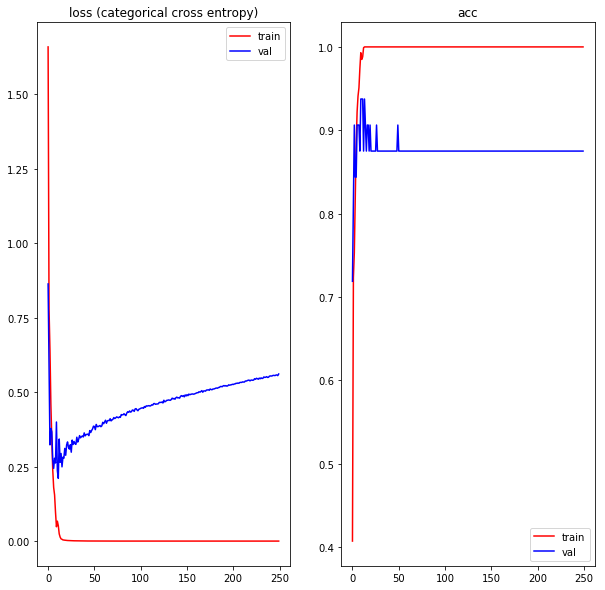

1 ResNet50_dataAug_False2019-06-01_18_31_default


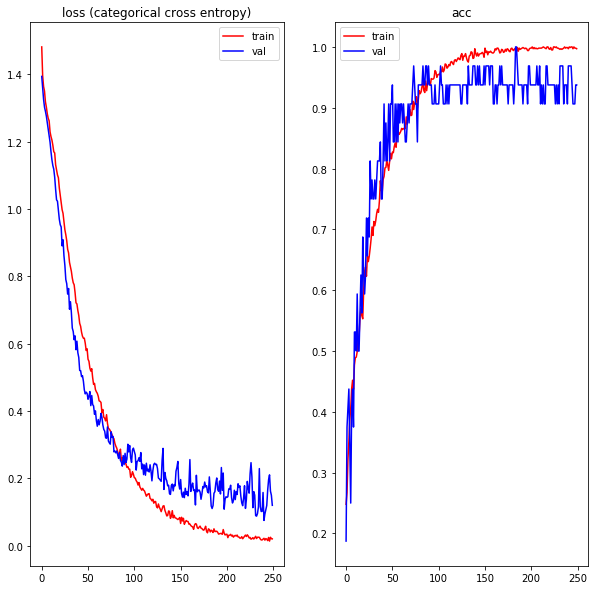

2 InceptionV3_dataAug_False2019-06-01_20_41_default


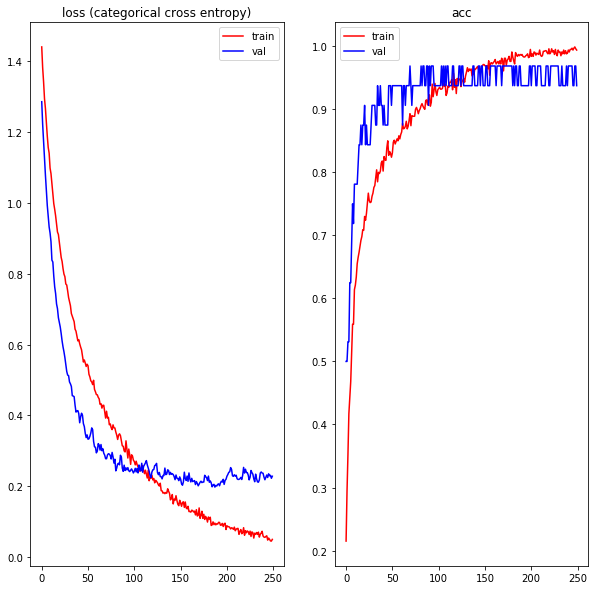

In [5]:
dirList = [VGG16Path, ResNet50Path, InceptionPath, ] #XceptionPath
modelNames = ["VGG16", "ResNet50", "InceptionV3", ] #"Xception"
modelPred = {}
for i, (expDir, modelName) in enumerate(zip(dirList, modelNames)):
    print(i, expDir)
    expPath = join(modelsPath, expDir)
    assert(os.path.isdir(expPath))
    '''
    modelPath = join(expPath, "{}.hdf5".format(modelName))
    try:
        model = load_model(modelPath)
        model.summary()
    except:
        print('cannot load model')
    '''
    histPath = join(expPath, "{}_History.csv".format(modelName)) 
    modelHist = pd.read_csv(histPath, index_col=0)
    plotModelHist(modelHist)
    yTestPred = np.load(join(expPath, "yTestPred.npy"))
    modelPred[modelName] = yTestPred

In [8]:
classMap = {
    "NORMAL": 0,
    "DRUSEN": 1,
    "CNV": 2,
    "DME": 3}


yTrue1Hot = to_categorical(yTrueTest)
yTrueTestUrgent = UrgentVRoutne(yTrue1Hot, classMap).astype(np.int)


In [22]:
AccListVGG16 = []
SensListVGG16 = []
SpecListVGG16 = []

aucListVGG16 = []
fprsListVGG16 = []
tprsListVGG16 = []

metricDict = {}
for model_i in modelPred.keys():
    print(model_i)
    '''
    if modelName == "VGG16":
        yTrueTest = yTrueTest224
    else:
        yTrueTest = yTrueTest299
    '''
    yTestPred = modelPred[model_i]
    classAcc = accuracy_score(yTrueTest,
                              yTestPred.argmax(axis=1))
    print('\t accuracy: {0:.3g}'.format(classAcc))
    yTestPredUrgent = UrgentVRoutne(yTestPred, classMap)
    print()
    print('\t binary (urgent vs non-urgent)')
    scores = reportBinaryScores(yTrueTestUrgent, yTestPredUrgent, v=1)
    acc, tpr, tnr, plr, nlr = scores
    
    fprs, tprs, _ = roc_curve(yTrueTestUrgent, yTestPredUrgent)
    aucUrgent = auc(fprs, tprs)
    print('\t auc {0:.3g}'.format(aucUrgent))

    metricDict[model_i] = {}
    metricDict[model_i]["acc"] = acc
    metricDict[model_i]["tpr"] = tpr
    metricDict[model_i]["tnr"] = tnr
    metricDict[model_i]["aucUrgent"] = aucUrgent
    metricDict[model_i]["fprs"] = fprs
    metricDict[model_i]["tprs"] = tprs
    
    AccListVGG16.append(acc)
    SensListVGG16.append(tpr)
    SpecListVGG16.append(tnr)
    
    aucListVGG16.append(aucUrgent)
    fprsListVGG16.append(fprs)
    tprsListVGG16.append(tprs)

VGG16
	 accuracy: 0.894

	 binary (urgent vs non-urgent)
	 accuracy: 0.924
	 sensitivity 0.932
	 specificity 0.915
	 positive likelihood ratio 11
	 negative likelihood ratio 0.0745


	 auc 0.974
ResNet50
	 accuracy: 0.252

	 binary (urgent vs non-urgent)
	 accuracy: 0.496
	 sensitivity 0.525
	 specificity 0.467
	 positive likelihood ratio 0.984
	 negative likelihood ratio 1.02


	 auc 0.513
InceptionV3
	 accuracy: 0.257

	 binary (urgent vs non-urgent)
	 accuracy: 0.51
	 sensitivity 0.517
	 specificity 0.504
	 positive likelihood ratio 1.04
	 negative likelihood ratio 0.959


	 auc 0.509


In [12]:
metricsDF = pd.DataFrame(index=modelPred.keys(), columns=['acc', 'tpr', 'tnr', 'auc'])
metricsDF["acc"] = AccListVGG16
metricsDF["tpr"] = SensListVGG16
metricsDF["tnr"] = SpecListVGG16
metricsDF["auc"] = aucListVGG16


In [13]:
metricsDF

,acc,tpr,tnr,auc
VGG16,0.923554,0.931818,0.915289,0.973670
ResNet50,0.495868,0.524793,0.466942,0.512508
InceptionV3,0.510331,0.516529,0.504132,0.508768


In [14]:
reportedAcc = 0.934
reportedSens = 0.966
reportedSpec = 0.94
reportedAuc = 0.988

reportedMetrics = [reportedAcc, 
                   reportedSens, 
                   reportedSpec,
                   reportedAuc]

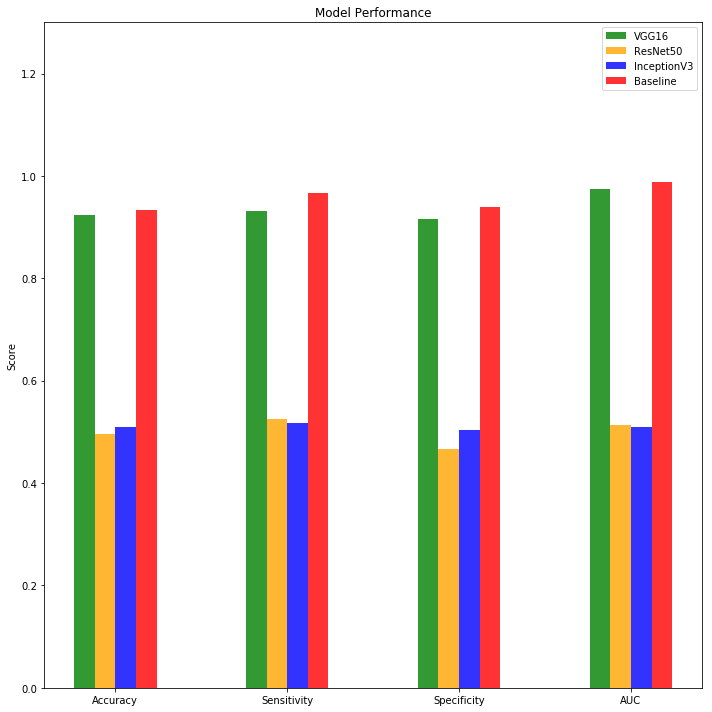

In [15]:
opacity = 0.8
error_config = {'ecolor': '0.3'}
n_groups = 4
nModels = len(modelPred.keys()) + 1

fig, ax = plt.subplots(figsize=(10, 10))
index = np.arange(n_groups)
bar_width = 0.12
colors = ['green', 'orange', 'blue', 'cyan']
for i, (vgg_i, c) in enumerate(zip(modelPred.keys(), colors)):
    
    xpos = index - nModels*bar_width/2 + (i+1)*bar_width
    rectsi = ax.bar(xpos, 
                    metricsDF.loc[vgg_i], bar_width,
                    alpha=opacity, color=c,
                    label=vgg_i)

xpos = index - nModels*bar_width/2 + (i+2)*bar_width
rects2 = ax.bar(xpos, reportedMetrics, bar_width,
                alpha=opacity, color='r', 
                label='Baseline')

#ax.set_xlabel('Group')
ax.set_ylabel('Score')
ax.set_title('Model Performance')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Accuracy', 'Sensitivity', 'Specificity', 'AUC'))
ax.set_ylim([0.0, 1.3])
ax.legend()

fig.tight_layout()
plt.show()
    

In [ ]:
with open()
modelPred